In [1]:
from google.colab import drive


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd gdrive/My Drive/Colab Notebooks/project_paylocity/ashrae-energy-prediction

/content/gdrive/My Drive/Colab Notebooks/project_paylocity/ashrae-energy-prediction


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from collections import Counter
import datetime
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import tqdm

from sklearn.metrics import mean_squared_log_error
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [4]:
train_preprocessed_may = pd.read_csv('train_preprocessed_may.csv')

In [5]:
train_preprocessed_may.shape

(4215009, 16)

In [6]:
train_preprocessed_may.groupby('site_id')['building_id'].count()

site_id
0     1076662
11     119459
12     315909
13    2702979
Name: building_id, dtype: int64

In [7]:
train_2 = train_preprocessed_may[train_preprocessed_may['site_id'].isin([12,11])]

In [8]:
#for simplicity purposes, we are considering 2 site ids

In [9]:
train_2["timestamp"] = pd.to_datetime(train_2["timestamp"])
train_2["hour"] = train_2["timestamp"].dt.hour
train_2["day"] = train_2["timestamp"].dt.day
train_2["weekend"] = train_2["timestamp"].dt.weekday
train_2["month"] = train_2["timestamp"].dt.month


train_2 = train_2.reset_index()

train_2 = train_2.drop(columns = ['index'], axis=1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [10]:
train_final = train_2.head(int(len(train_2)*(90/100)))
test_final = train_2[len(train_final):]

In [11]:
# train_final = train_final[(train_final['building_id']==1029)&(train_final['meter']==0)]
# test_final = test_final[(test_final['building_id']==1029)&(test_final['meter']==0)]

In [12]:
train_final.shape

(391831, 20)

In [13]:
test_final.shape

(43537, 20)

In [14]:
!pip install pmdarima

In [15]:
from pmdarima import auto_arima

In [16]:
train_final.head(2)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month
0,1029,0,2016-01-01,246.000,11,Education,152559,1970.0,3.0,-1.8,9.0,-3.2,0.0,1016.0,280.0,1.5,0,1,4,1
1,1029,3,2016-01-01,140.929,11,Education,152559,1970.0,3.0,-1.8,9.0,-3.2,0.0,1016.0,280.0,1.5,0,1,4,1


In [17]:
exogenous_features = ['meter','square_feet','floor_count','air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
                      'wind_direction', 'wind_speed', 'hour','day','weekend','month']


In [18]:
train_final[exogenous_features].isnull().sum()

meter                 0
square_feet           0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
hour                  0
day                   0
weekend               0
month                 0
dtype: int64

In [19]:
def add_lags(df, window=3):
    group_df = df.groupby(['building_id','site_id'])
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        df[f'{col}_mean_lag{window}'] = lag_mean[col]
        df[f'{col}_max_lag{window}'] = lag_max[col]
        df[f'{col}_min_lag{window}'] = lag_min[col]
        df[f'{col}_std_lag{window}'] = lag_std[col]

In [20]:
# add_lags(train_final, window = 3)
# add_lags(test_final, window = 3)

In [21]:
def features_engineering3(df):
    
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df['square_feet'] =  np.log1p(df['square_feet']+1)   
    # Remove unimp Columns
    drop = ["timestamp"]
    df = df.drop(drop, axis=1)

    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [22]:
exogenous_features

['meter',
 'square_feet',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'hour',
 'day',
 'weekend',
 'month']

In [23]:
import pmdarima as pm

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


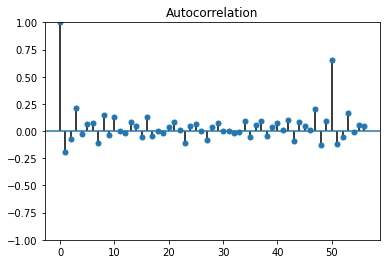

In [24]:
pm.plot_acf(np.log(train_final["meter_reading"]+1))

In [25]:
model = auto_arima(
	np.log(train_final["meter_reading"]+1),
	exogenous=train_final[exogenous_features],
  D = None,
  d = None,
  maxiter = 3,
  n_fits = 3,
  start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=1, max_q=1, max_P=1, max_Q=1,max_d = 1, max_D =1,
  seasonal = False,
  max_order = 3,
	trace=True,
	error_action="ignore",
	suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1450258.803, Time=237.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1695920.190, Time=297.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1582117.141, Time=666.83 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1444950.632, Time=221.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6350333.779, Time=191.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1442268.824, Time=207.75 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1449935.226, Time=225.61 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1582204.024, Time=629.56 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2678.477 seconds


In [26]:
model

ARIMA(maxiter=3, order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [27]:
forecast = model.predict(n_periods=len(test_final),  exogenous=test_final[exogenous_features])

In [28]:
from sklearn.metrics import mean_squared_log_error

In [29]:
evaluation1 = mean_squared_log_error(forecast, (test_final["meter_reading"]+1))
print(evaluation1)

6.26243061215381


In [21]:
#using arima, outputs are hard to figure out